In [ ]:
# Ensure relevant packages are installed
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install biopython
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install tensorflow

In [1]:
from Bio import SeqIO
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

#Encode a single protein sequence into a vector with 96*20 = 1920 binary variables
def one_hot_encoder(MSA_str, alphabet):
    # define a mapping of characters to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    # integer encode input data
    integer_encoded = [char_to_int[char] for char in MSA_str]
    # one hot encode integers
    onehot_encoded = list()
    for value in integer_encoded:
        if value == char_to_int.get("-"):
            letter = [0 for value in range(len(alphabet)-1)]
        else:
            letter = [0 for value in range(len(alphabet)-1)]
            letter[value] = 1
        onehot_encoded.append(letter)
        
    #At this point, we have 96 vectors of 20 binary variables, one vector per letter
    #Concatenate them to have one vector of 1920 variables
    concatenated = onehot_encoded[0]
    for i in range(len(onehot_encoded)-1):
        concatenated = np.concatenate((concatenated, onehot_encoded[i+1]), axis = None)
        
    return concatenated

In [2]:
#Use one_hot_encoder on all the elements in one file: end up with N vectors of 1920 variables
def read_and_encode(file, alphabet):
    
    #Store relevant data in dictionary
    #Keys: sequence_number; values: sequence, functionality (functional_true, functional_false)
    data_dict = {}
    index=1
    #name sequences as "sequence_#": do this in roundabout way since third file does not name thep thus
    for seq_record in SeqIO.parse(file, "fasta"):
        data_dict['sequence_' + str(index)] = seq_record.seq
        index += 1
        data_dict[seq_record.id] = seq_record.seq, seq_record.description.replace(seq_record.id+' ','',1)
    
    #Array one: one vector per string => [N, 20*92]
    encoded_data = np.empty([len(data_dict), (len(alphabet)-1)*(len(data_dict['sequence_1'][0]))])
    #Array 2: one binary label per string => [N]
    labels = np.empty(len(data_dict))
    
    #Encode every sequence in the file
    for i in range(len(data_dict)):
        sequence = data_dict.get("sequence_"+str(i+1))[0] #this [0] makes the function crash for the unlabeled file
        encoded_data[i] = one_hot_encoder(sequence, alphabet)
        
        #if functional_true => encode 1 in labels
        if data_dict.get("sequence_"+str(i+1))[1] == "functional_true":
            labels[i]=1
        #if functional_false => encode 0 in labels
        elif data_dict.get("sequence_"+str(i+1))[1] == "functional_false":
            labels[i]=0
      
    return encoded_data, labels

#Slightly different for unlabelled data
def read_and_encode_unlab(file, alphabet):
    data_dict = {}
    index=1
    for seq_record in SeqIO.parse(file, "fasta"):
        data_dict['sequence_' + str(index)] = seq_record.seq
        index += 1

    encoded_data_unlab = np.empty([len(data_dict), 1920])
    number_of_corrupted_lines = 0
    corrupted_indexes = []

    for i in range(len(data_dict)):
        sequence = data_dict.get("sequence_"+str(i+1))
        #Some Xs are hanging around in the files, need to avoid them
        try:
            encoded_data_unlab[i] = one_hot_encoder(sequence, alphabet)
        except:
            corrupted_indexes.append(i)
            number_of_corrupted_lines += 1

    print("The number of corrupted sequences is "+ str(number_of_corrupted_lines))

    for i in range(len(corrupted_indexes)):
        encoded_data_unlab = np.delete(encoded_data_unlab, i, axis = 0)
    return encoded_data_unlab

In [3]:
#Read files
#Check that everything works
alphabet ='ACDEFGHIKLMNPQRSTVWY-' #the alphabet we'll use the whole time

encoded_data_nat, labels_nat = read_and_encode("./MSA_nat_with_annotation.faa", alphabet)
print("The shapes of the oneshot encoded natural data and of the label files are " + str(np.shape(encoded_data_nat)) + " and " + str(np.shape(labels_nat))+" respectively")

encoded_data_art, labels_art = read_and_encode("./MSA_art.faa", alphabet)
print("The shapes of the oneshot encoded artificial data and of the label files are " + str(np.shape(encoded_data_art)) + " and " + str(np.shape(labels_art))+" respectively")

all_lab_data = np.concatenate((encoded_data_art, encoded_data_nat))
all_lab = np.concatenate((labels_nat, labels_art))
print("The shapes of all the oneshot encoded labeled data and of their label file are " + str(np.shape(all_lab_data)) + " and " + str(np.shape(all_lab))+" respectively")

encoded_data_unlab = read_and_encode_unlab("./MSA_nat_no_annotation.faa", alphabet)
print("The shape of the oneshot encoded unlabeled data is " + str(np.shape(encoded_data_unlab)))

The shapes of the oneshot encoded natural data and of the label files are (1130, 1920) and (1130,) respectively
The shapes of the oneshot encoded artificial data and of the label files are (1003, 1920) and (1003,) respectively
The shapes of all the oneshot encoded labeled data and of their label file are (2133, 1920) and (2133,) respectively
The number of corrupted sequences is 42
The shape of the oneshot encoded unlabeled data is (6269, 1920)


In [4]:
#Exercice 2: apply PCA
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt

#Standardizing the features: not needed - data is already scaled. But if we did:
#from sklearn.preprocessing import StandardScaler
#encoded_data = StandardScaler().fit_transform(encoded_data)
def apply_PCA(encoded_data):

    #Find number of components such that we keep, say, 95% of the variance when applying
    pca_test = PCA().fit(encoded_data)
    n_components= np.where(np.cumsum(pca_test.explained_variance_ratio_) > 0.95)
    min_n = n_components[0][0]
    print("With " + str(min_n) + " components, we keep 95% of the variance!")
    
    fig = plt.figure(figsize=(8,8))
    plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
    plt.axvline(x=min_n, color='red', linestyle='--')
    plt.xlabel("number of components")
    plt.ylabel("cumulative explained variance")

    
    #Apply PCA with this optimal n
    pca = PCA(n_components=min_n)
    principalComponents = pca.fit_transform(encoded_data)

    two_compo_var = (pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100
    print("With the first 2 components, we only keep " + str(two_compo_var) + "% of the variance")
    
    return principalComponents

#Visualize the first two principle components
def visualize_pcs(principalComponents, labels, title):
    #red => 0 => functional_false; green => 1 => functional_true
    if(labels is None):
        colors = []
    else:
        colors = ['red','green']
        
    fig = plt.figure(figsize=(8,8))
    plt.scatter(principalComponents[:,0], principalComponents[:,1], c=labels, marker = '+', 
                cmap=matplotlib.colors.ListedColormap(colors))
    plt.xlabel('Principal Component - 1',fontsize=20)
    plt.ylabel('Principal Component - 2',fontsize=20)
    plt.title(title ,fontsize=20)

We have 1130 natural labelled sequences
With 501 components, we keep 95% of the variance!
With the first 2 components, we only keep 7.6387908526858395% of the variance
We have 1003 artificial labelled sequences
With 312 components, we keep 95% of the variance!
With the first 2 components, we only keep 11.919627907598615% of the variance
We have 2133 labelled sequences
With 529 components, we keep 95% of the variance!
With the first 2 components, we only keep 8.427748326678365% of the variance
We have 6269 unlabelled sequences
With 512 components, we keep 95% of the variance!
With the first 2 components, we only keep 16.502261045451913% of the variance


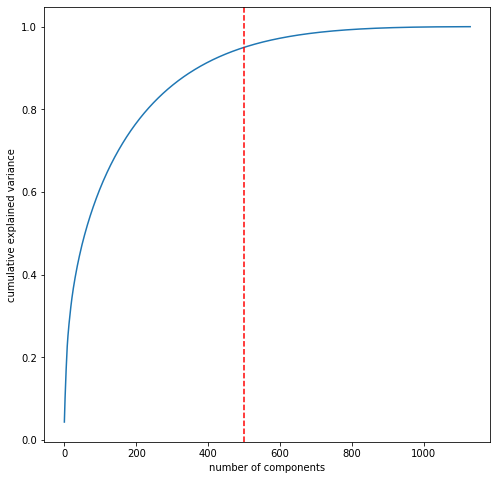

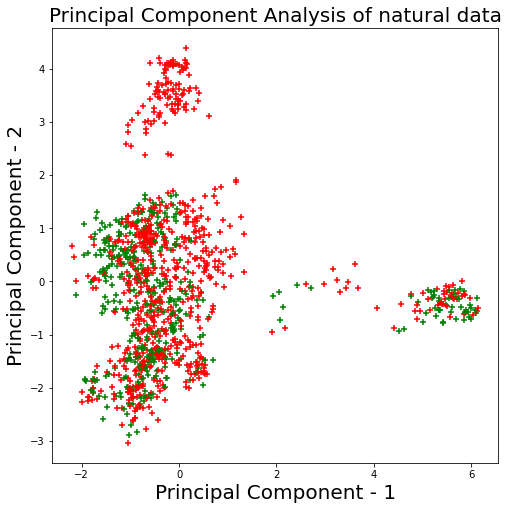

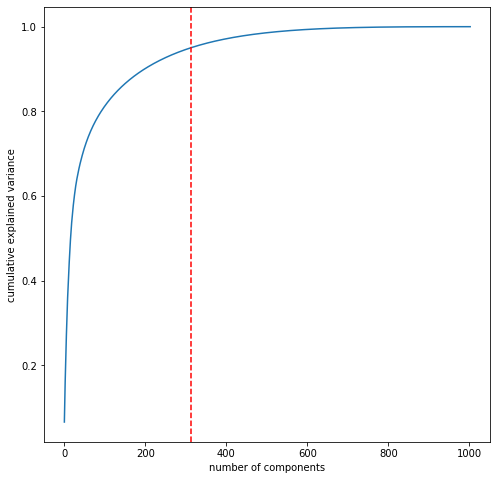

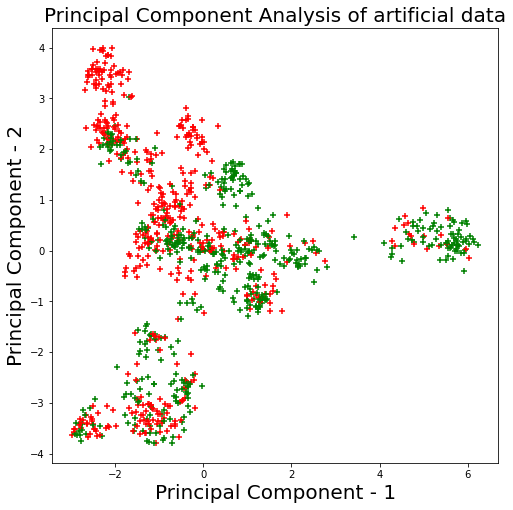

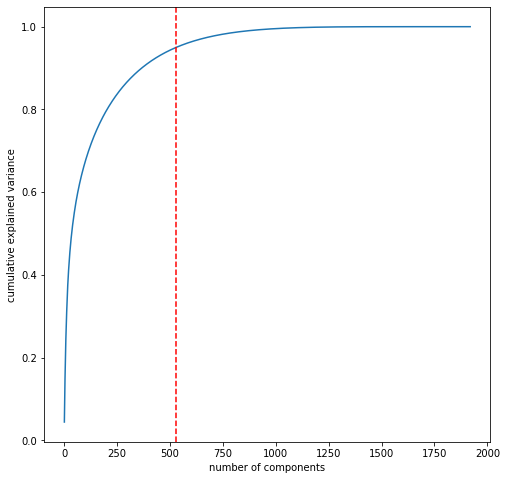

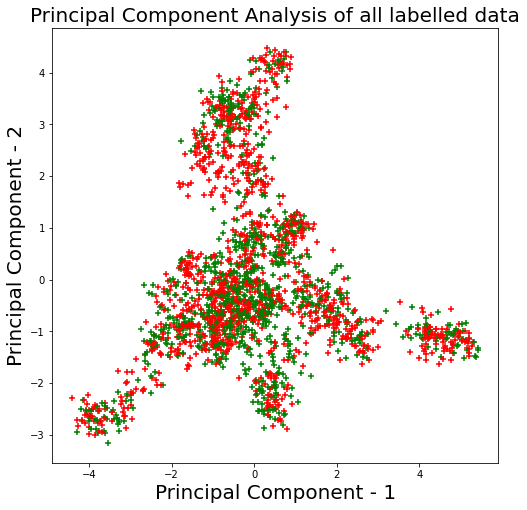

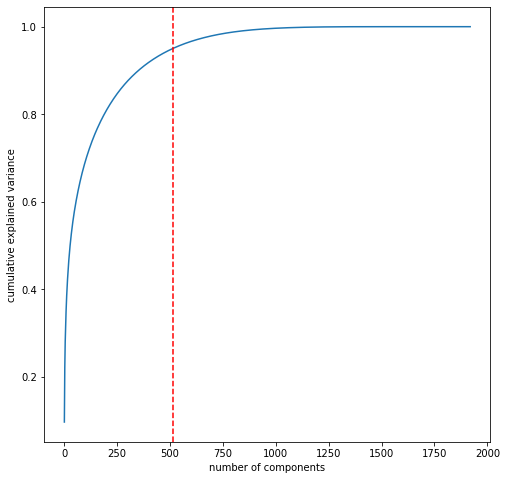

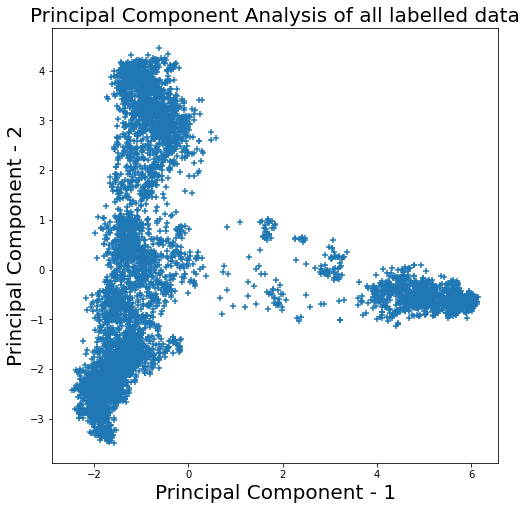

In [5]:
#Try this way, but we'll do it like above I guess
print("We have " + str(np.shape(encoded_data_nat)[0]) + " natural labelled sequences")
pcs_nat = apply_PCA(encoded_data_nat)
visualize_pcs(pcs_nat, labels_nat, "Principal Component Analysis of natural data")

print("We have " + str(np.shape(encoded_data_art)[0]) + " artificial labelled sequences")
pcs_art = apply_PCA(encoded_data_art)
visualize_pcs(pcs_art, labels_art, "Principal Component Analysis of artificial data")

print("We have " + str(np.shape(all_lab_data)[0]) + " labelled sequences")
pcs_all = apply_PCA(all_lab_data)
visualize_pcs(pcs_all, all_lab, "Principal Component Analysis of all labelled data")

print("We have " + str(np.shape(encoded_data_unlab)[0]) + " unlabelled sequences")
pcs_unlab = apply_PCA(encoded_data_unlab)
visualize_pcs(pcs_unlab, None, "Principal Component Analysis of all labelled data")

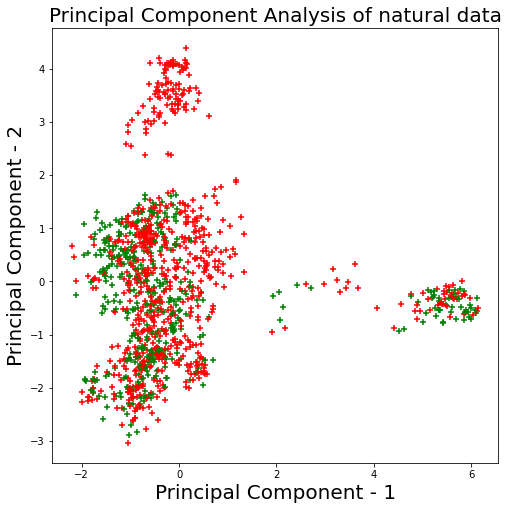

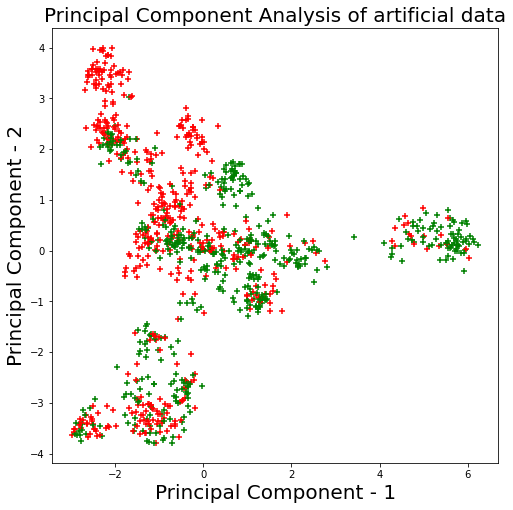

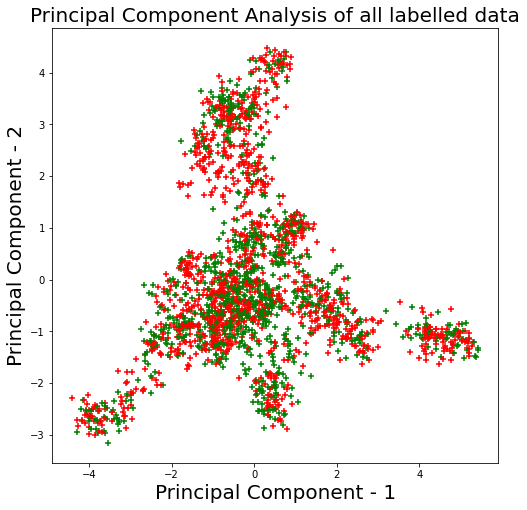

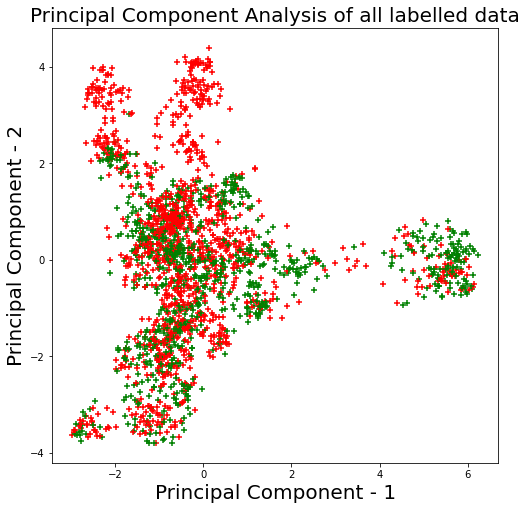

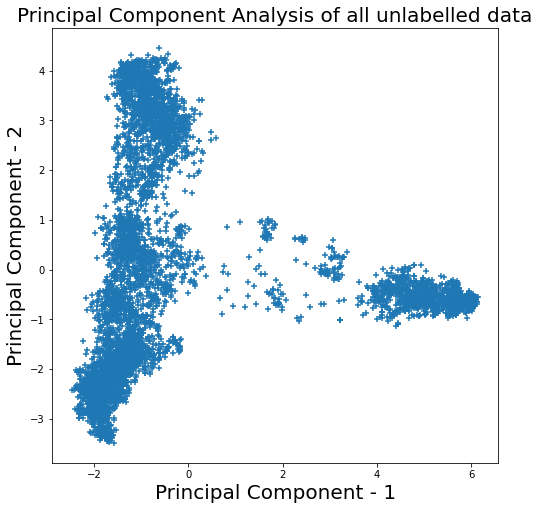

In [6]:
modelPCA = PCA(n_components=500)

nat_pcs = modelPCA.fit_transform(encoded_data_nat)
art_pcs = modelPCA.fit_transform(encoded_data_art)
all_pcs = modelPCA.fit_transform(all_lab_data)
unlab_pcs = modelPCA.fit_transform(encoded_data_unlab)

visualize_pcs(nat_pcs, labels_nat, "Principal Component Analysis of natural data")
visualize_pcs(art_pcs, labels_art, "Principal Component Analysis of artificial data")
visualize_pcs(all_pcs, all_lab, "Principal Component Analysis of all labelled data")
visualize_pcs(np.concatenate((nat_pcs, art_pcs)), np.concatenate((labels_nat, labels_art)), "Principal Component Analysis of all labelled data")
visualize_pcs(unlab_pcs, None, "Principal Component Analysis of all unlabelled data")

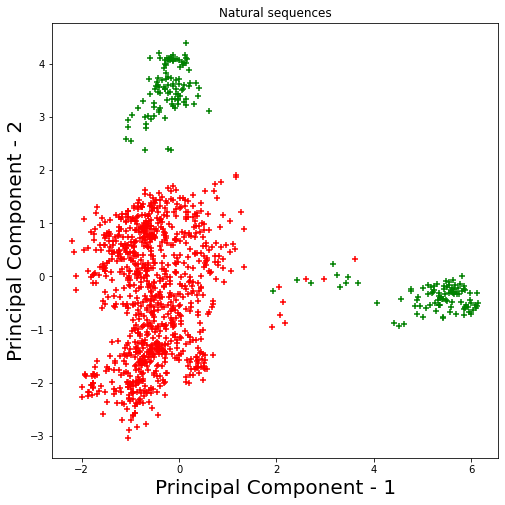

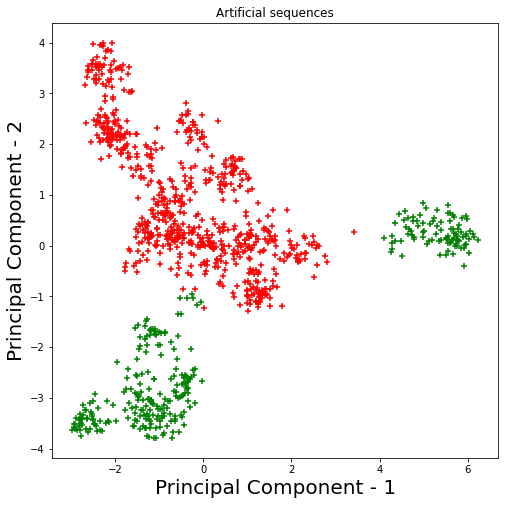

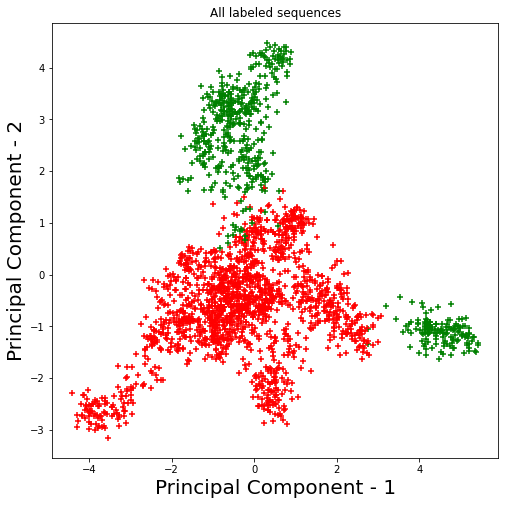

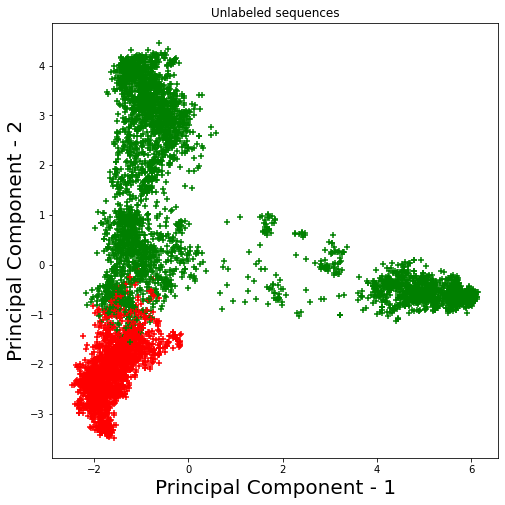

In [68]:
#Exercice 3: clustering

from sklearn.cluster import AgglomerativeClustering

def two_compo_cluster(data, pcs, title):

    method = AgglomerativeClustering(n_clusters = 3)
    clustered = method.fit(data)
    labels = clustered.labels_
    colors = ['red','green']

    fig = plt.figure(figsize=(8,8))
    plt.scatter(pcs[:,0], pcs[:,1], c=labels, marker = '+',
            cmap=matplotlib.colors.ListedColormap(colors))
    plt.xlabel('Principal Component - 1',fontsize=20)
    plt.ylabel('Principal Component - 2',fontsize=20)
    plt.title(title)

two_compo_cluster(encoded_data_nat, pcs_nat, "Natural sequences")
two_compo_cluster(encoded_data_art, pcs_art, "Artificial sequences")
two_compo_cluster(initial_data, pcs_full_data, "All labeled sequences")
two_compo_cluster(encoded_data_unlab, pcs_unlab, "Unlabeled sequences")

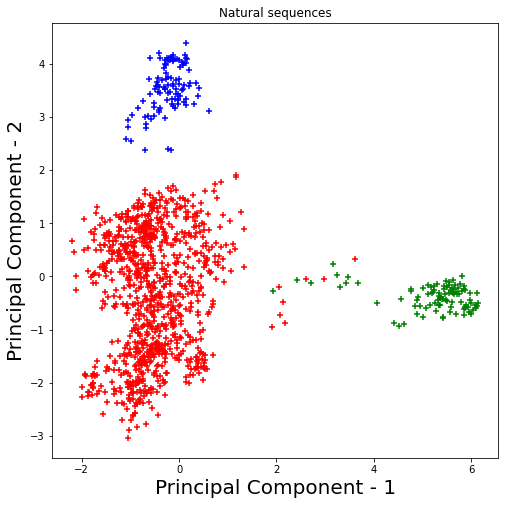

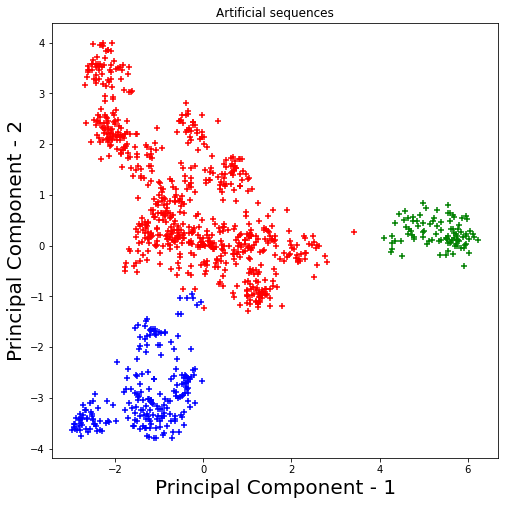

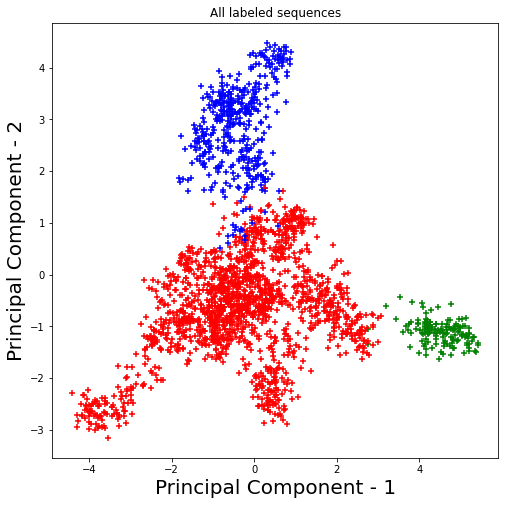

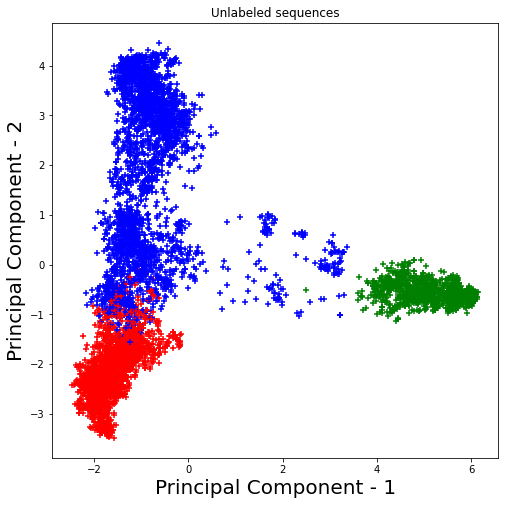

In [69]:
def three_compo_cluster(data, pcs, title):

    method = AgglomerativeClustering(n_clusters = 3)
    clustered = method.fit(data)
    labels = clustered.labels_
    colors = ['red','green', 'blue']

    fig = plt.figure(figsize=(8,8))
    plt.scatter(pcs[:,0], pcs[:,1], c=labels, marker = '+',
            cmap=matplotlib.colors.ListedColormap(colors))
    plt.xlabel('Principal Component - 1',fontsize=20)
    plt.ylabel('Principal Component - 2',fontsize=20)
    plt.title(title)
    

three_compo_cluster(encoded_data_nat, pcs_nat, "Natural sequences")
three_compo_cluster(encoded_data_art, pcs_art, "Artificial sequences")
three_compo_cluster(initial_data, pcs_full_data, "All labeled sequences")
three_compo_cluster(encoded_data_unlab, pcs_unlab, "Unlabeled sequences")

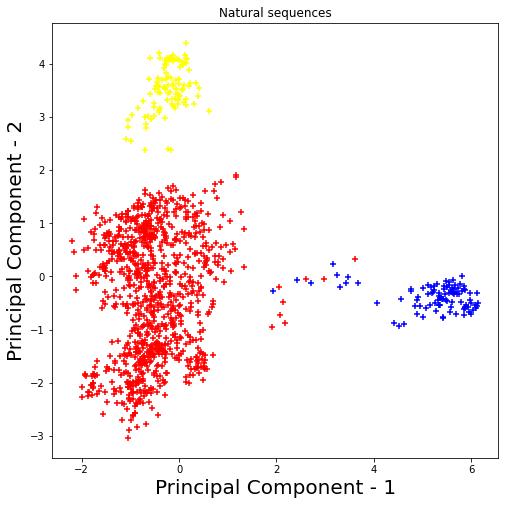

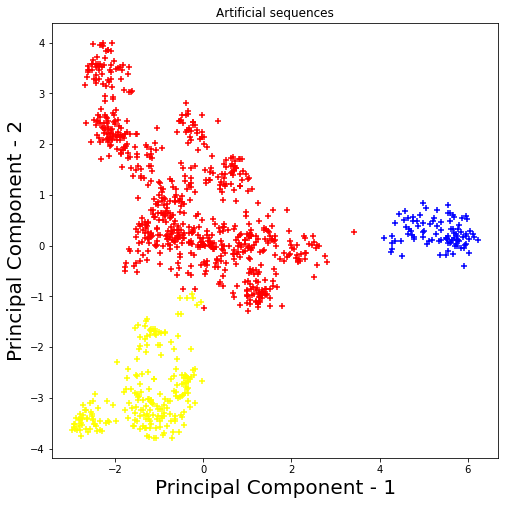

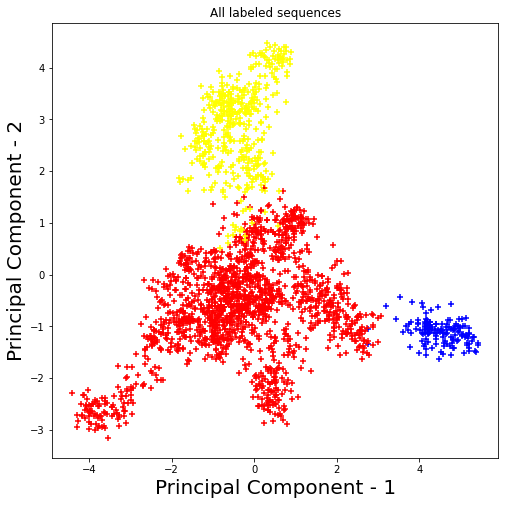

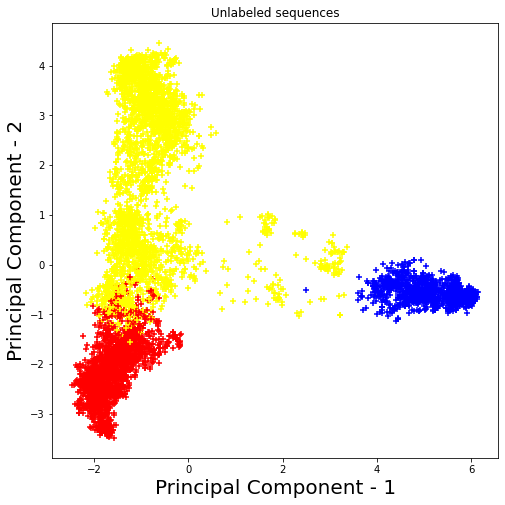

In [25]:
def four_compo_cluster(data, pcs, title):

    method = AgglomerativeClustering(n_clusters = 3)
    clustered = method.fit(data)
    labels = clustered.labels_
    colors = ['red','green', 'blue', "yellow"]

    fig = plt.figure(figsize=(8,8))
    plt.scatter(pcs[:,0], pcs[:,1], c=labels, marker = '+',
            cmap=matplotlib.colors.ListedColormap(colors))
    plt.xlabel('Principal Component - 1',fontsize=20)
    plt.ylabel('Principal Component - 2',fontsize=20)
    plt.title(title)
    

four_compo_cluster(encoded_data_nat, pcs_nat, "Natural sequences")
four_compo_cluster(encoded_data_art, pcs_art, "Artificial sequences")
four_compo_cluster(initial_data, pcs_full_data, "All labeled sequences")
four_compo_cluster(encoded_data_unlab, pcs_unlab, "Unlabeled sequences")

In [101]:
#Supervised learning: NN
from keras import losses, optimizers, metrics, callbacks
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Input, Dense, Add

params = {
    'compilation': {
            'optimizer': Adam(
                learning_rate=0.001
                ),
            'loss': losses.MeanSquaredError(),
            'metrics': [metrics.MeanSquaredError(), metrics.MeanAbsoluteError()],
        },
    'fit': {
        'batch_size': 32,
        'epochs': 100,
        'callbacks' : [
            callbacks.EarlyStopping(monitor='loss', patience=7), 
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)]
            }
          }

#Set up network
model = Sequential() 
input_layer = Dense(32, input_shape=(np.shape(input_data)[1],)) 
model.add(input_layer) 
hidden_layer = Dense(64, activation='relu')
model.add(hidden_layer)
hidden_layer = Dense(64, activation='relu')
model.add(hidden_layer) 
output_layer = Dense(1, activation='sigmoid') 
model.add(output_layer)

model.compile(**params['compilation'])

#Def fraction train/test/validation
fraction_train = 0.8
fraction_test = 0.1

stop_1 = int(fraction_train*len(output_data))
stop_2 = stop_1 + int(fraction_test*len(output_data))

X_train, y_train = input_data[:stop_1], output_data[:stop_1]
X_test, y_test = input_data[stop_1+1:stop_2], output_data[stop_1+1:stop_2]
X_validation, y_validation = input_data[stop_2+1:], output_data[stop_2+1:]

print('Training network (this might take a while)...')
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    verbose=0,
    **params['fit']
)

print('Number of epochs run:', len(history.history['loss']))

# Calculate and print scores
print('Evaluating model performance on test set...')
scores = model.evaluate(X_test, y_test, verbose=0)

max_metrics_name_length = len(max(model.metrics_names, key=len))
print()
print(' Scores '.center(max_metrics_name_length + 13, '='))
line = '{:<%i} : {:.4e}' % max_metrics_name_length
for i in range(len(model.metrics_names)):
    print(line.format(model.metrics_names[i], scores[i]))
print()

Training network (this might take a while)...
Number of epochs run: 79
Evaluating model performance on test set...

============ Scores ============
loss                : 1.1992e-01
mean_squared_error  : 1.1992e-01
mean_absolute_error : 1.6335e-01



(2133, 1920)
[[9.9883461e-01]
 [4.8530698e-03]
 [8.0171397e-10]
 ...
 [9.5793569e-01]
 [9.6982276e-01]
 [4.1838950e-01]]
(2133, 1)


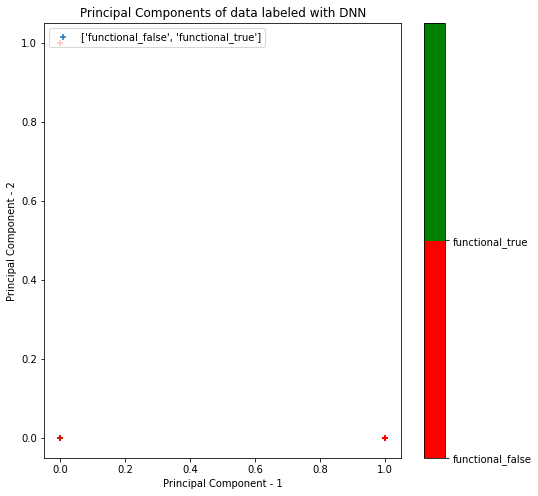

In [102]:
print(np.shape(input_data))
pred_labels = model.predict(input_data)
print(pred_labels)
print(np.shape(pred_labels))

#red => 0 => functional_false; green => 1 => functional_true
colors = ['red','green']
groups = ['functional_false', 'functional_true']

fig = plt.figure(figsize=(8,8))
plt.scatter(input_data[:,0], input_data[:,1], c=pred_labels, marker = '+', label=groups,
            cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('Principal Component - 1')
plt.ylabel('Principal Component - 2')
plt.legend(loc=2)
plt.title("Principal Components of data labeled with DNN")

cb = plt.colorbar()
loc = np.arange(0,max(labels),max(labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(["functional_false", "functional_true"])